In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn import preprocessing, model_selection
from sklearn.impute import SimpleImputer

In [2]:
df = pd.read_csv('../data/merged.csv')

In [3]:
X = df.drop(columns=['ruid', 'visit_id', 'admit_date', 'discharge_date', 'readmit_time', 
                     'total_encounters', 'dob', 'dod'])

## Training-Validation-Testing Split

In [4]:
train = X[X.group=='train']
train.drop(columns='group', inplace=True)

valid = X[X.group=='valid']
valid.drop(columns='group', inplace=True)

test = X[X.group=='test']
test.drop(columns='group', inplace=True)

assert(X.shape[0]==(train.shape[0] + valid.shape[0] + test.shape[0]))

/Volumes/AlvinSD/anaconda3/envs/Bios8366/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


## Patterns of Missingness

In [5]:
%load_ext rpy2.ipython

In [6]:
import warnings
from rpy2.rinterface import RRuntimeWarning
warnings.filterwarnings("ignore", category=RRuntimeWarning)
#%R install.packages('rms', dependencies=T)

In [7]:
%R library(Hmisc)

array(['Hmisc', 'ggplot2', 'Formula', 'survival', 'lattice', 'tools',
       'stats', 'graphics', 'grDevices', 'utils', 'datasets', 'methods',
       'base'], dtype='<U9')

In [8]:
%%R -i valid -o valid_imp

# ensure all variables have appropriate R structures
valid$sex <- as.factor(valid$sex)
valid$race <- as.factor(valid$race)
valid$pregnancy_indicator <- as.factor(valid$pregnancy_indicator)
valid$readmit_30d <- as.factor(valid$readmit_30d)

med_imp <- function(x) {
    if (is.numeric(x)) {
        x <- as.numeric(impute(x, fun=median))
    }
    else {
        x <- as.factor(x)
    }
}

valid_imp <- data.frame(lapply(valid, FUN=med_imp))

/Volumes/AlvinSD/anaconda3/envs/Bios8366/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


In [9]:
%%R -i test -o test_imp

# ensure all variables have appropriate R structures
test$sex <- as.factor(test$sex)
test$race <- as.factor(test$race)
test$pregnancy_indicator <- as.factor(test$pregnancy_indicator)
test$readmit_30d <- as.factor(test$readmit_30d)

test_imp <- data.frame(lapply(test, FUN=med_imp))

In [10]:
%%R -i train
# ensure all variables have appropriate R structures
train$sex <- as.factor(train$sex)
train$race <- as.factor(train$race)
train$pregnancy_indicator <- as.factor(train$pregnancy_indicator)

# include outcome variable in imputation
train$readmit_30d <- as.factor(train$readmit_30d)

In [11]:
%%R 
na.patterns.all <- naclus(train)

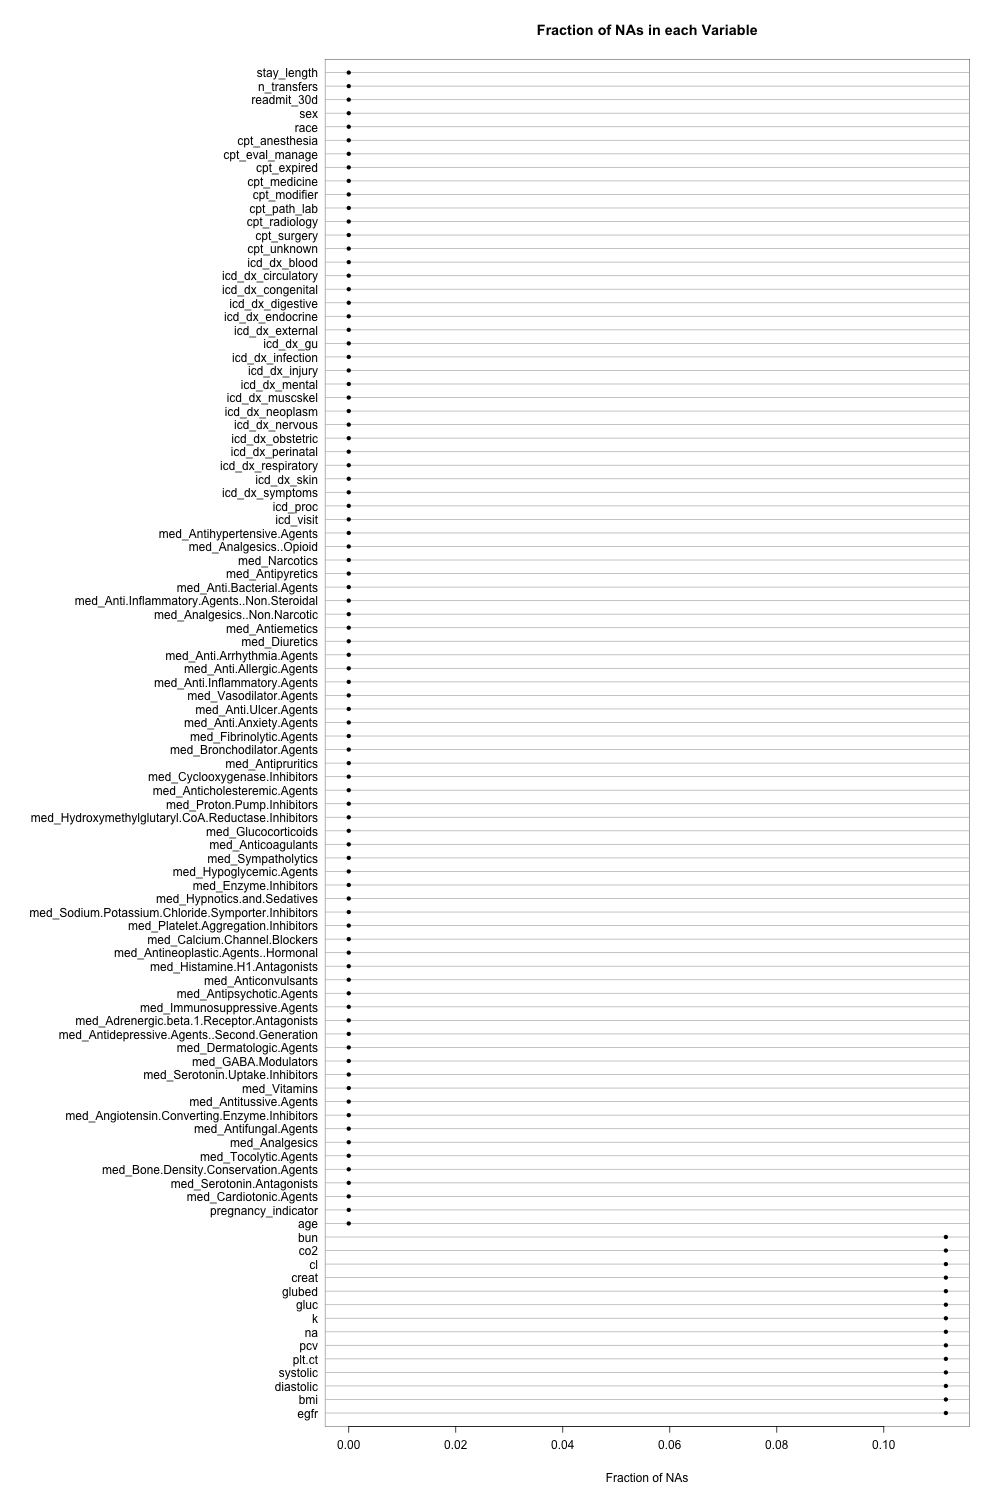

In [12]:
%%R -h 1500 -w 1000 -u px
naplot(na.patterns.all, which='na per var')

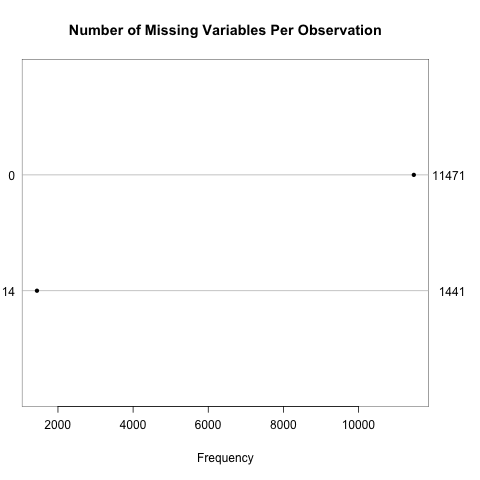

In [13]:
%%R -h 480 -w 480 -u px
naplot(na.patterns.all, which='na per obs')

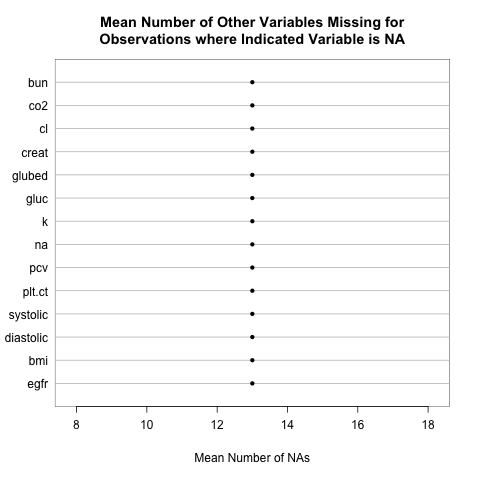

In [14]:
%%R -h 480 -w 480 -u px
naplot(na.patterns.all, which='mean na')

In [15]:
%%R

# separate categorical & numerical features
cat_cols <- c('sex', 'race', 'pregnancy_indicator', 'readmit_30d')
num_cols <- names(train[, !names(train) %in% cat_cols])

# convert all predictors into R formula
vars <- paste(num_cols, collapse=' + ')
formula <- paste('~', vars)

# attempting all variables (but singular matrix resulted)
#formula <- as.formula(paste(formula), ' + sex-1 + race-1 + pregnancy_indicator-1'))

# numerical values only
formula <- as.formula(paste(formula))

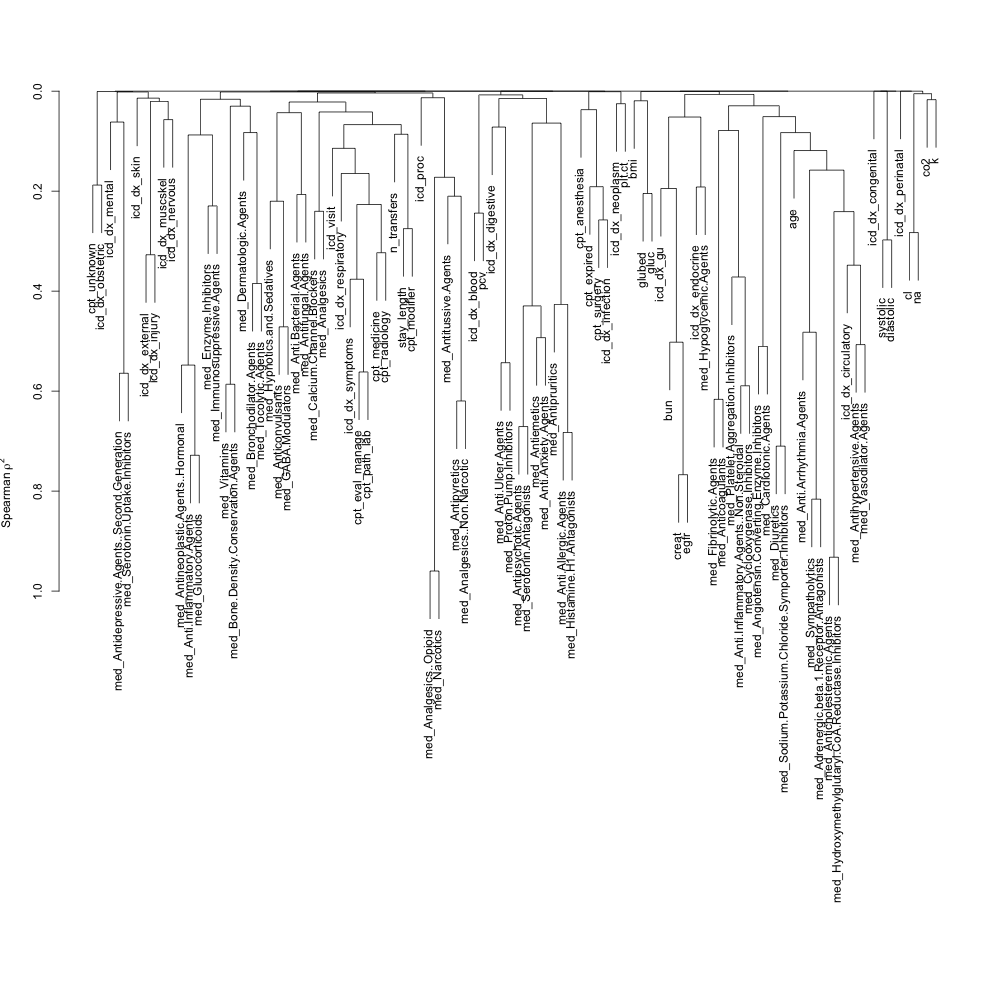

In [16]:
%%R -h 1000 -w 1000 -u px

vc <- varclus(formula, sim='spearman', data=train)
plot(vc) 

## Imputation

Takes about 20 minutes to run a single imputation. 

Convergence criterion:7.277 3.376 1.276 1.181 0.96 0.894 0.922 0.786 0.667 
0.714 0.611 0.525 0.496 0.468 0.515 0.446 0.391 0.338 0.318 
0.291 0.316 0.274 0.237 0.217 0.191 0.189 0.19 0.191 0.186 
0.175 0.164 0.162 0.164 0.165 0.162 0.153 0.145 0.146 0.144 
0.143 0.137 0.133 0.127 0.123 0.122 0.123 0.116 0.117 0.088 

Convergence in 50 iterations
R-squared achieved in predicting each variable:

                                       stay_length 
                                             0.877 
                                       n_transfers 
                                             0.609 
                                       readmit_30d 
                                             0.080 
                                               sex 
                                             0.395 
                                              race 
                                             0.313 
                                    cpt_anesthesia 
                              

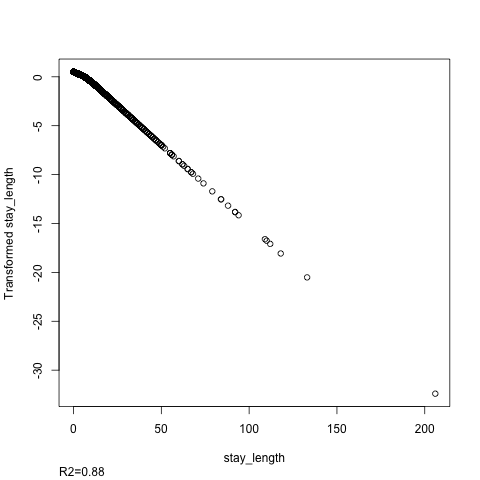

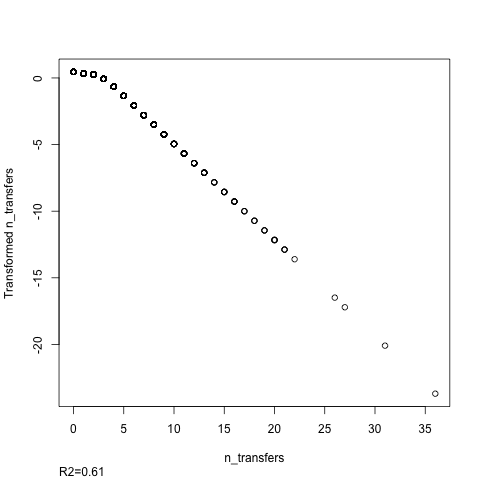

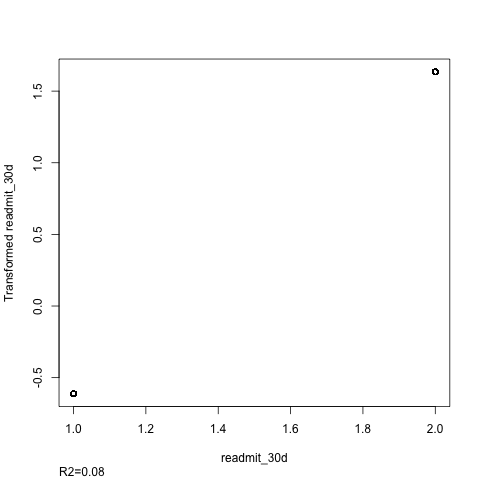

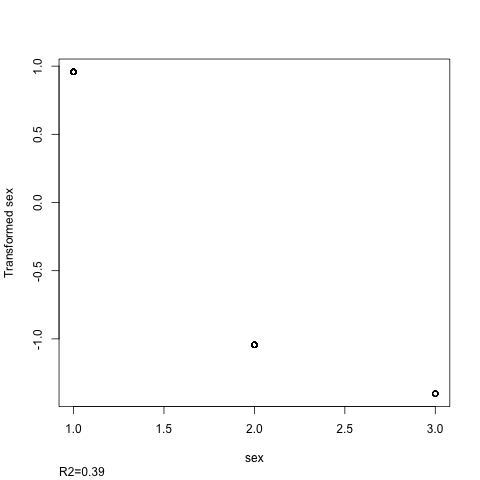

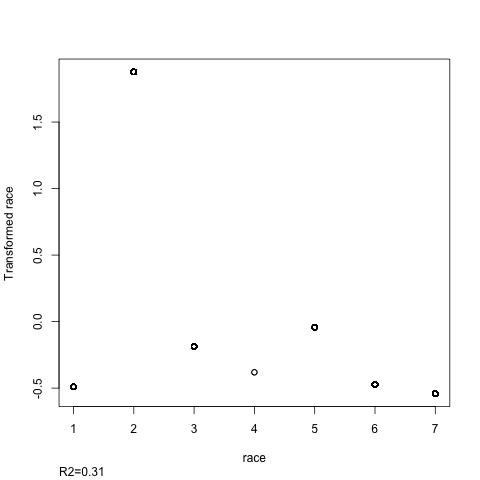

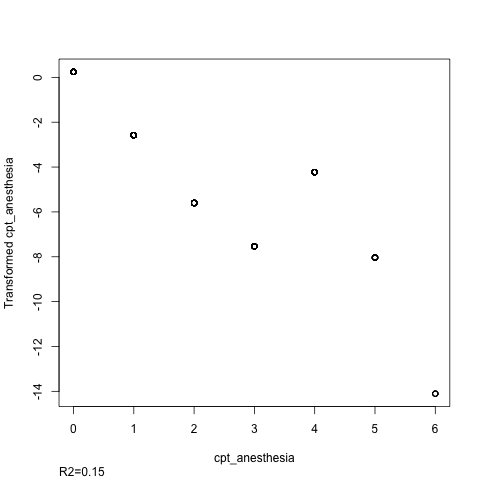

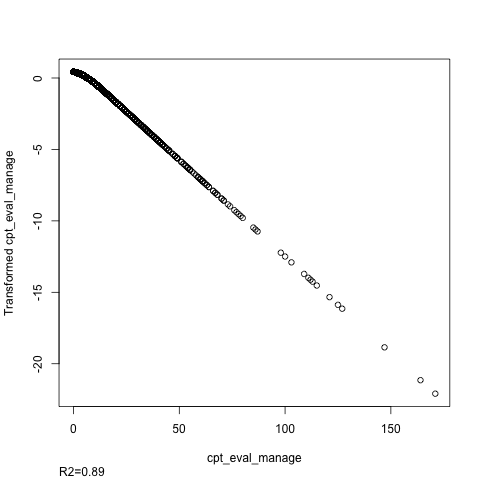

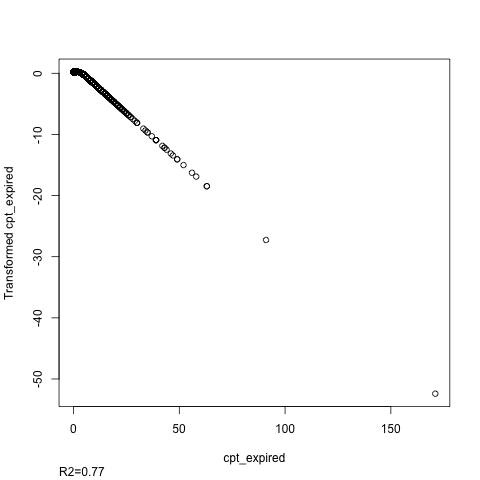

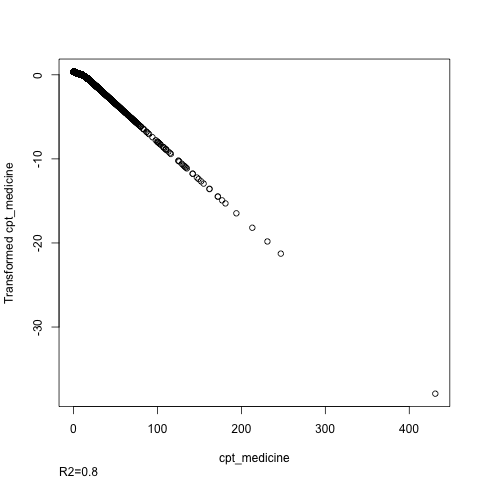

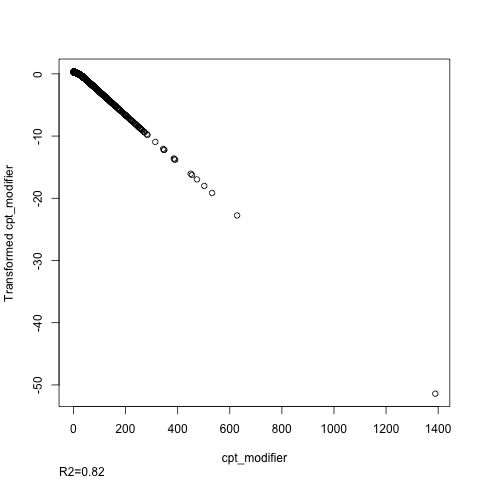

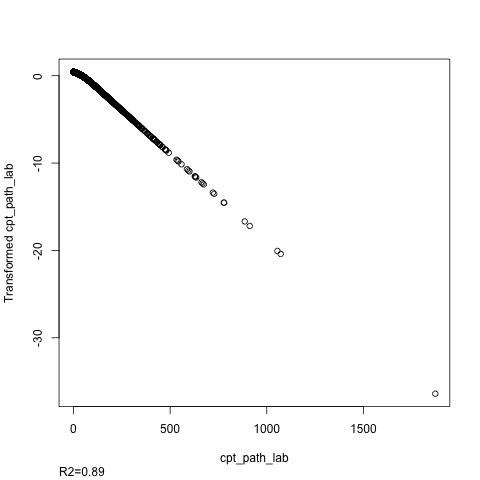

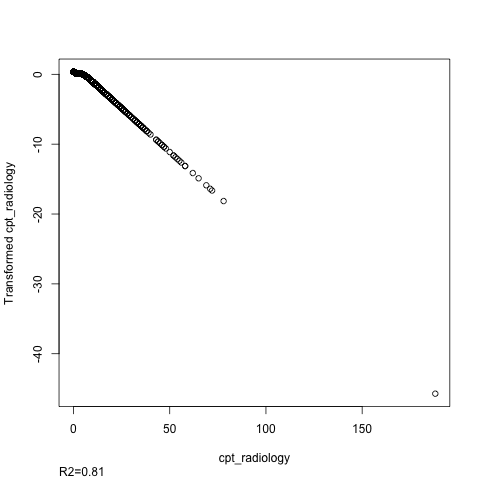

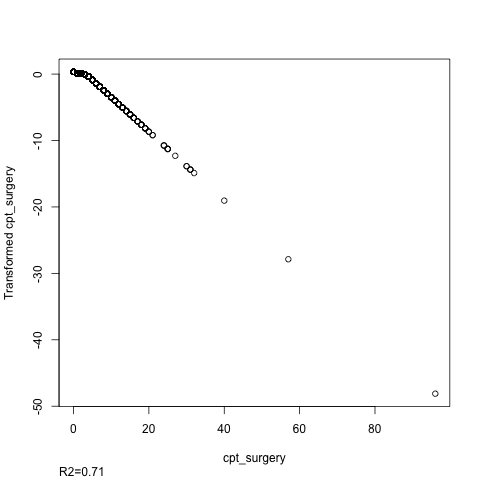

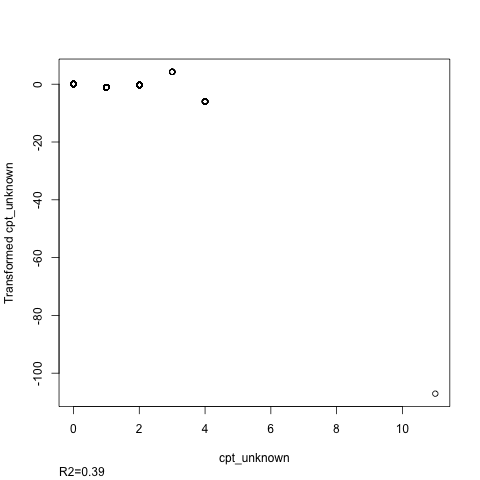

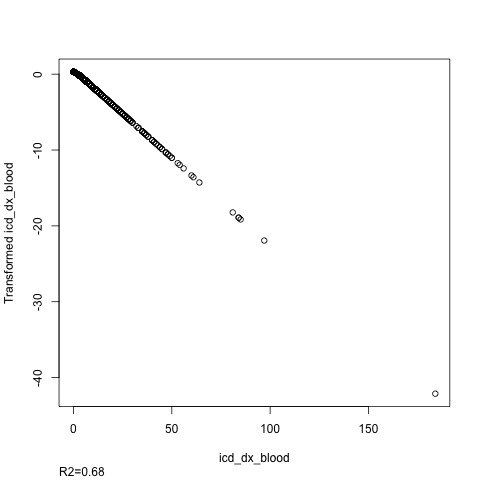

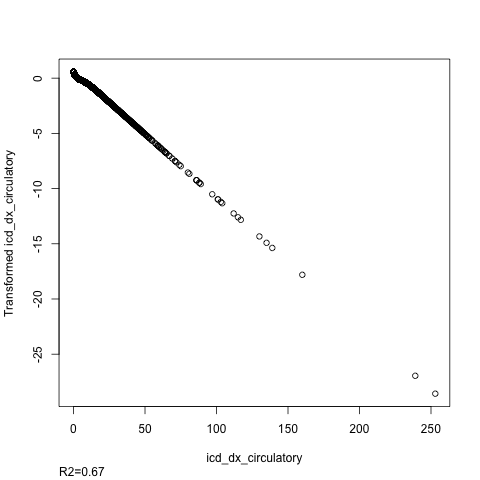

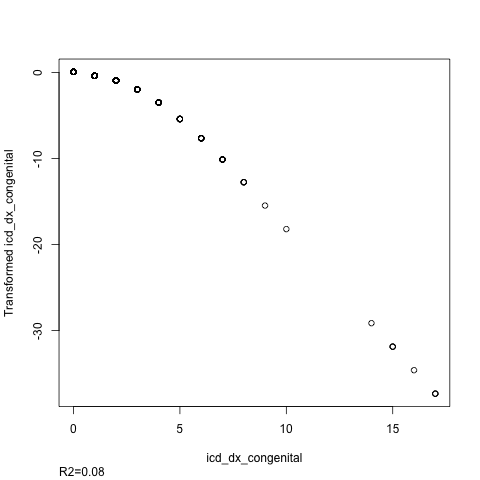

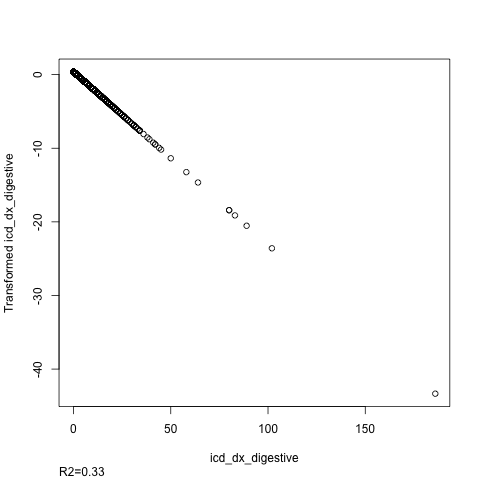

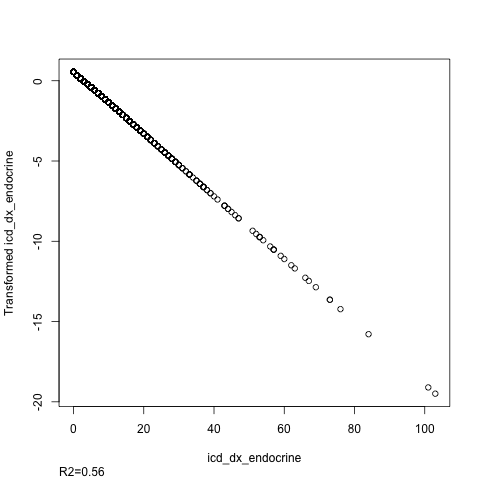

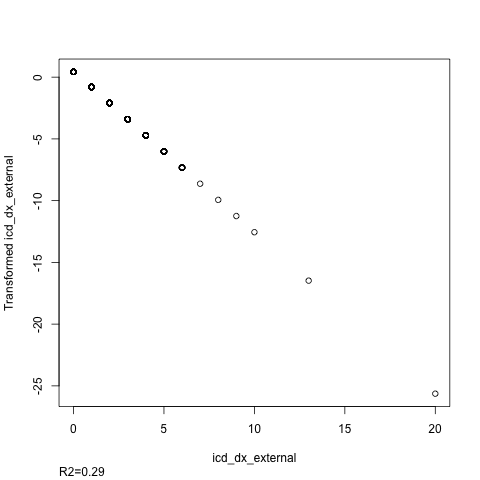

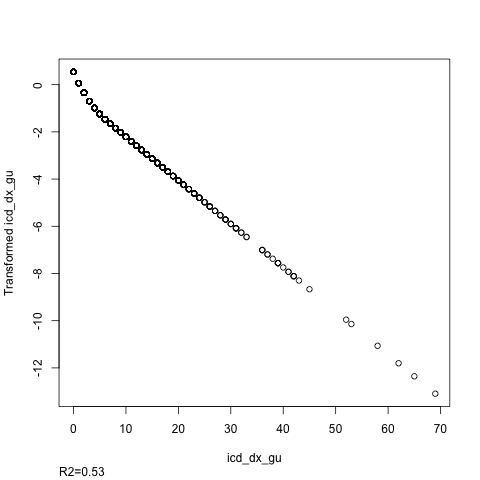

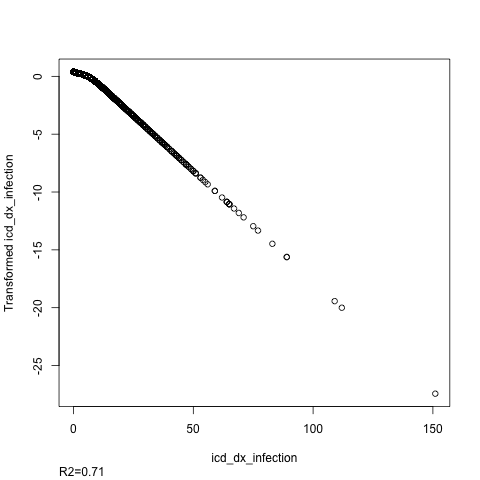

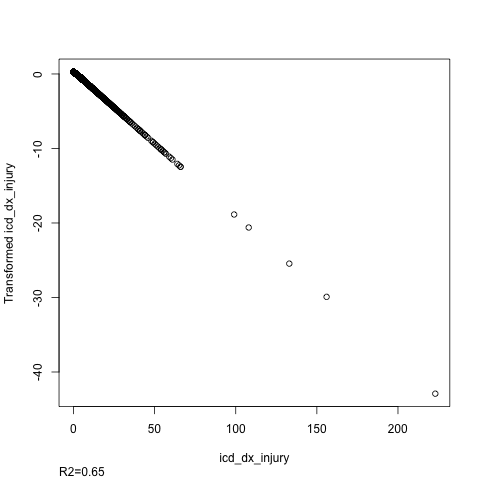

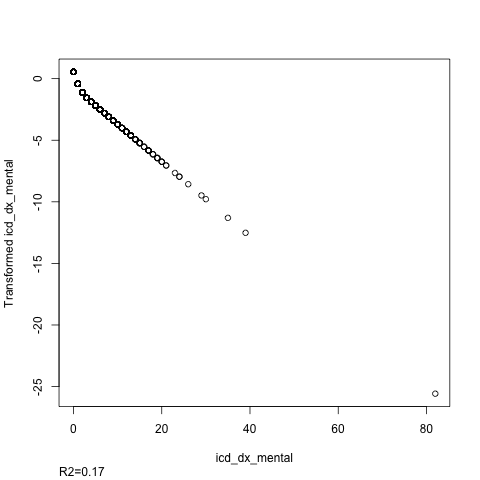

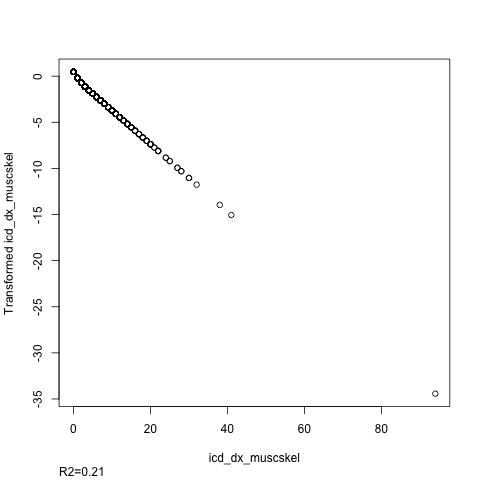

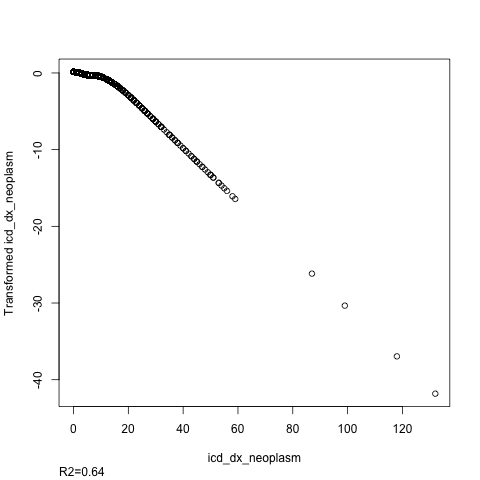

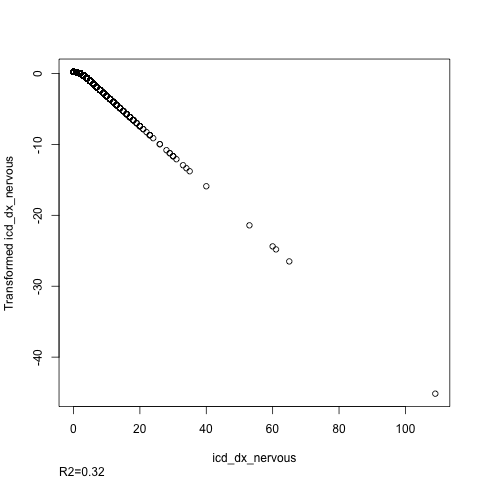

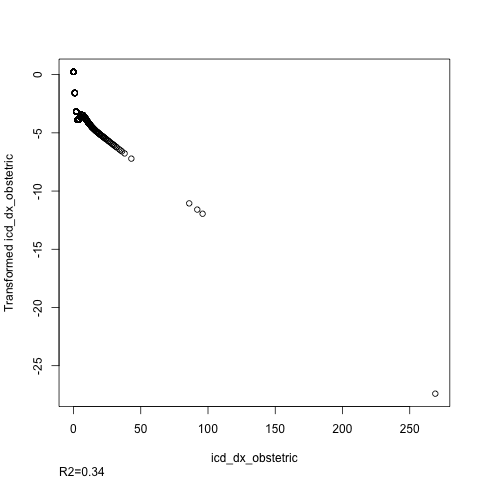

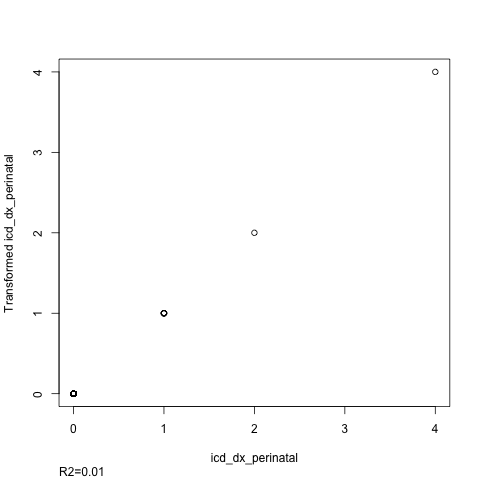

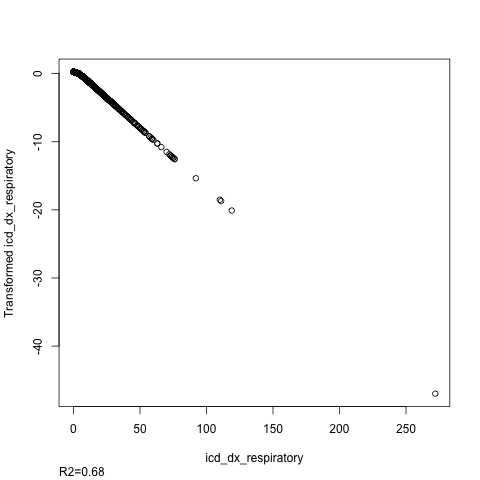

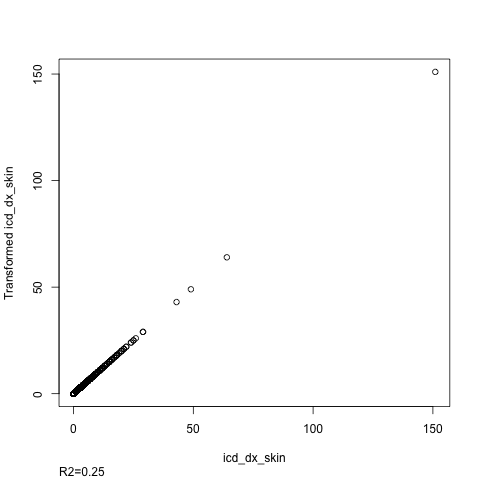

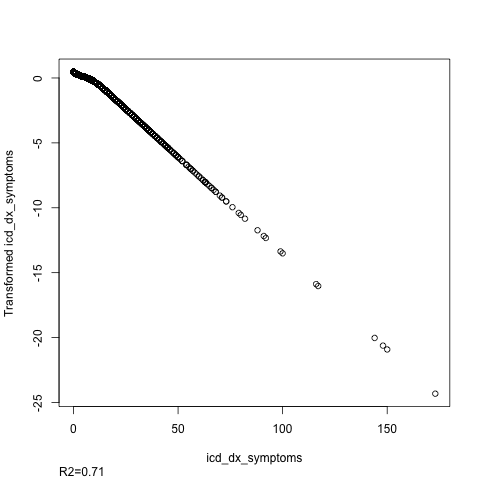

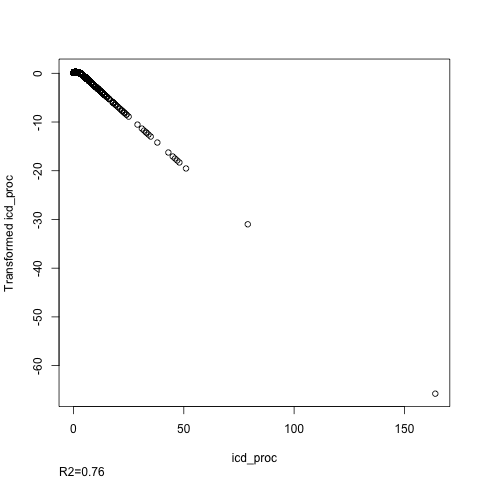

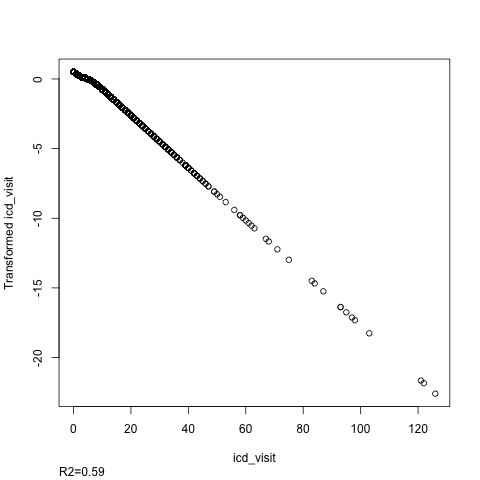

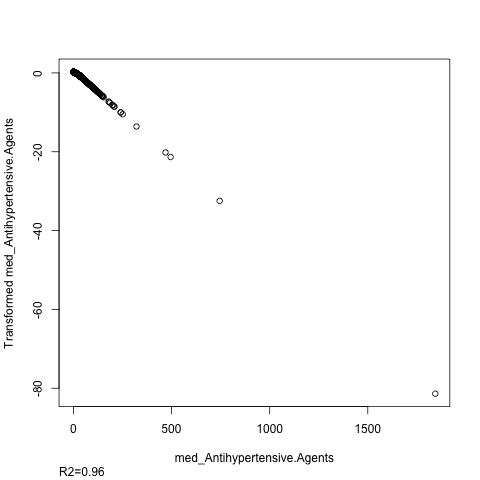

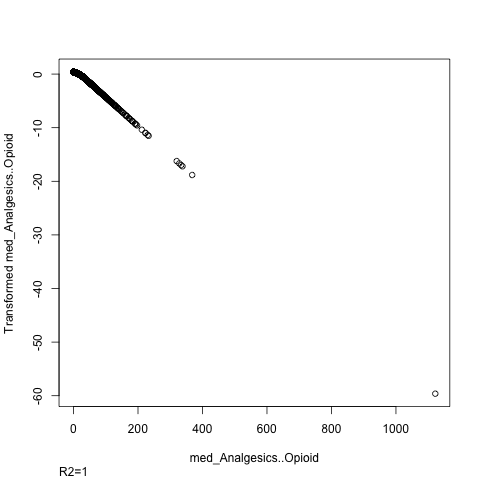

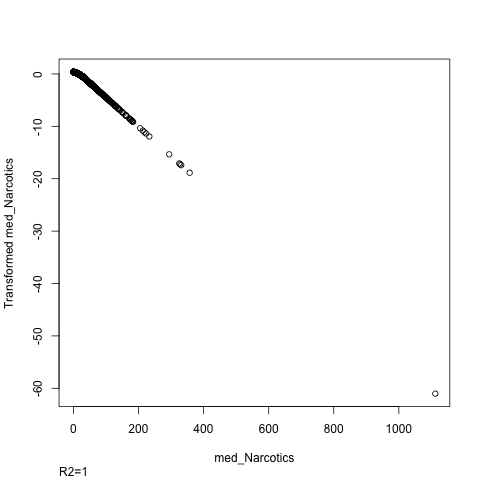

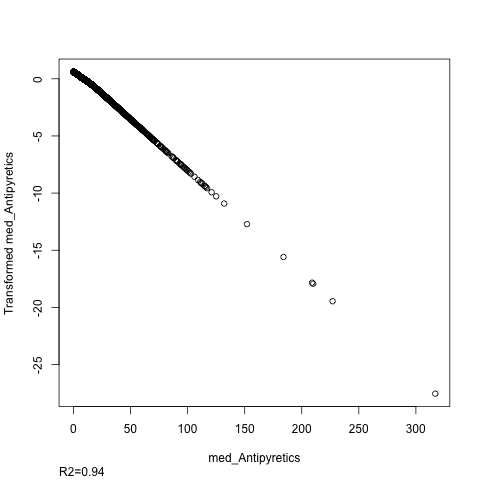

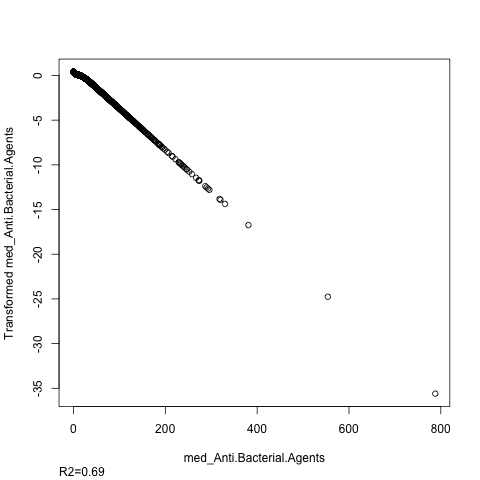

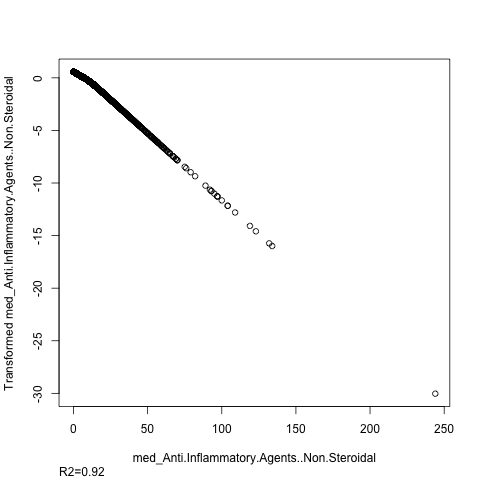

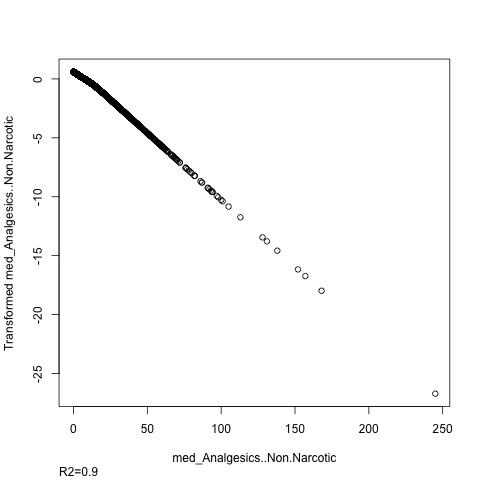

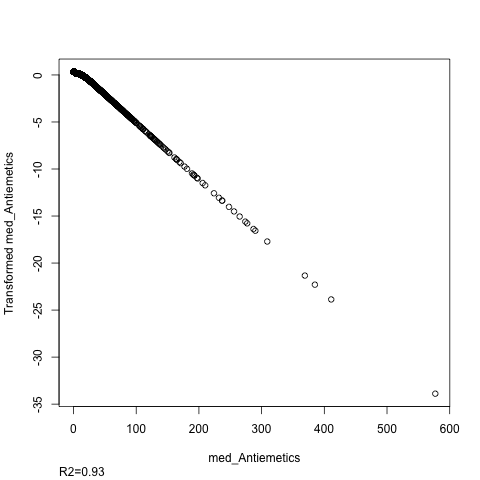

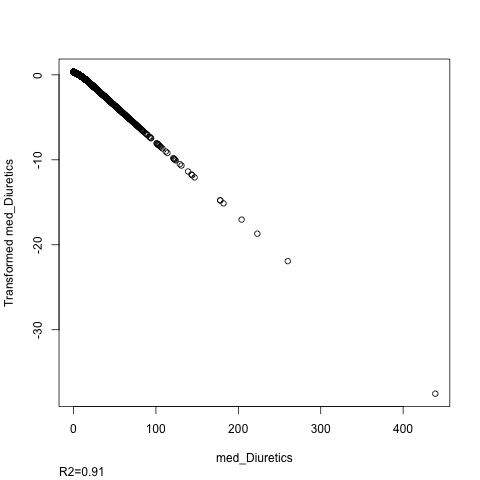

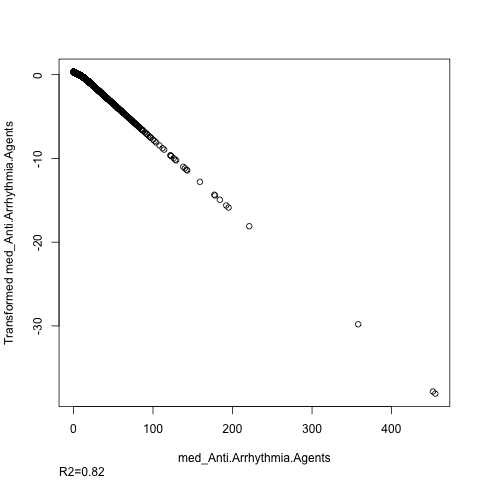

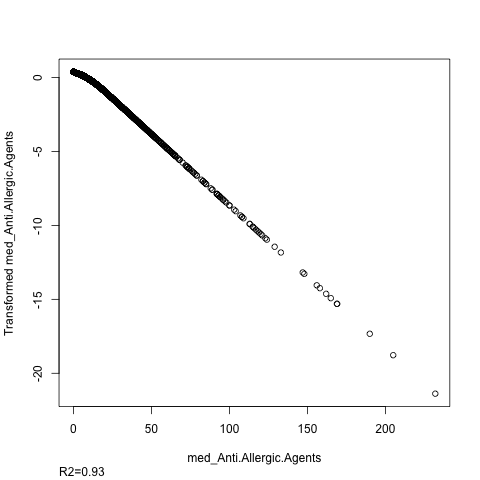

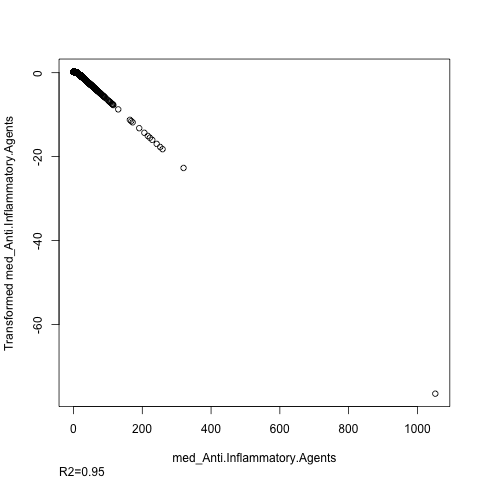

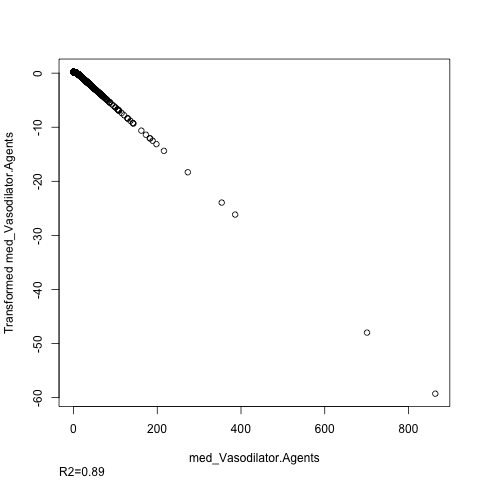

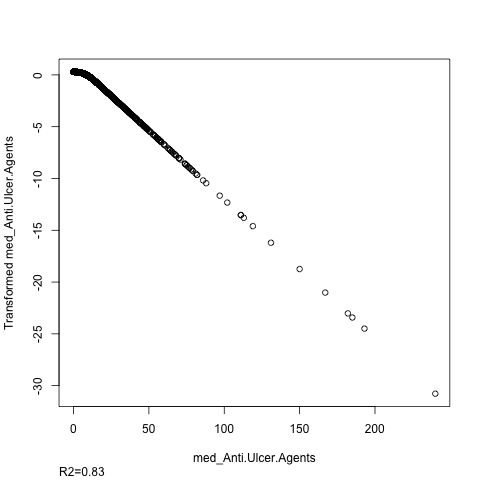

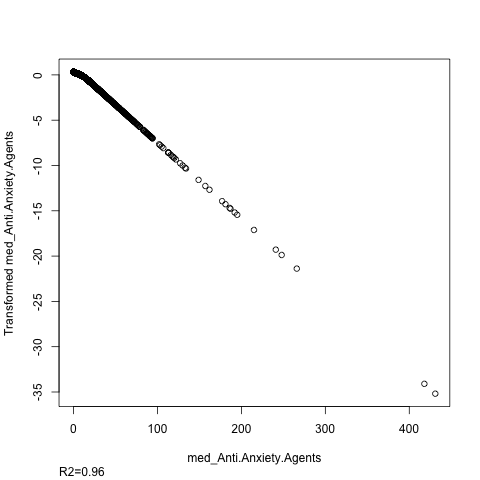

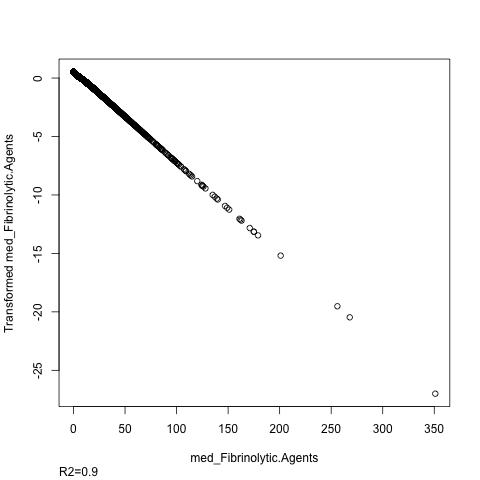

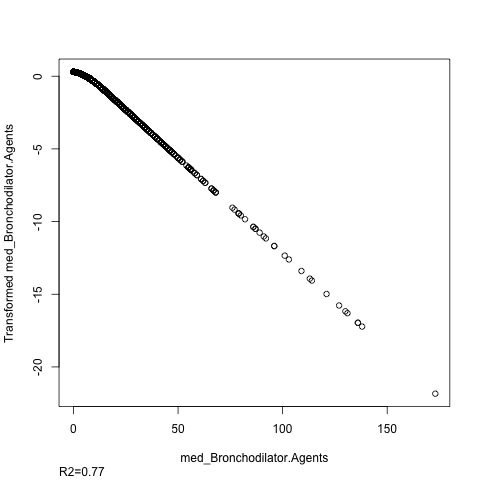

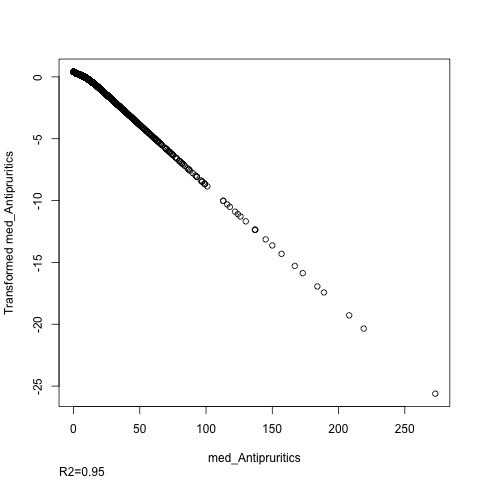

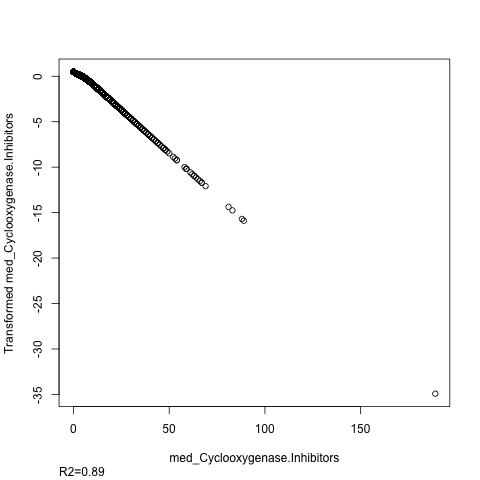

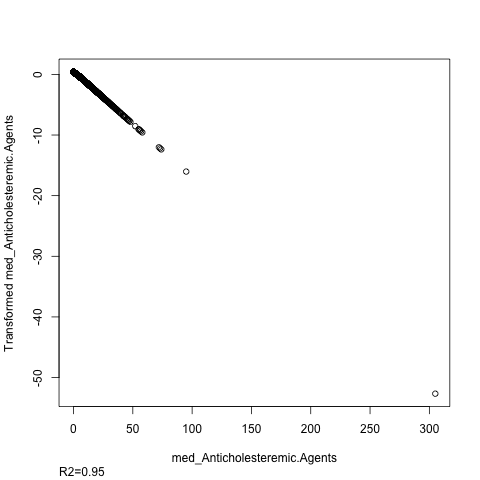

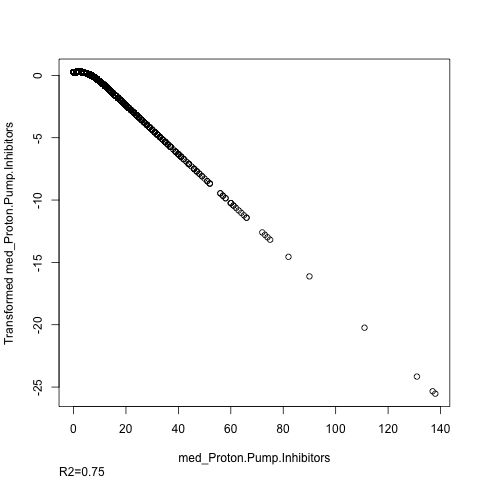

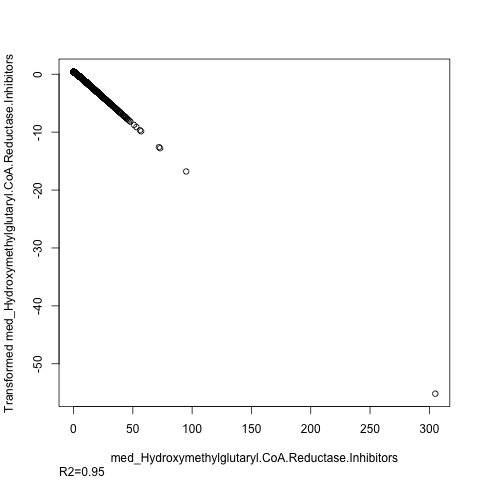

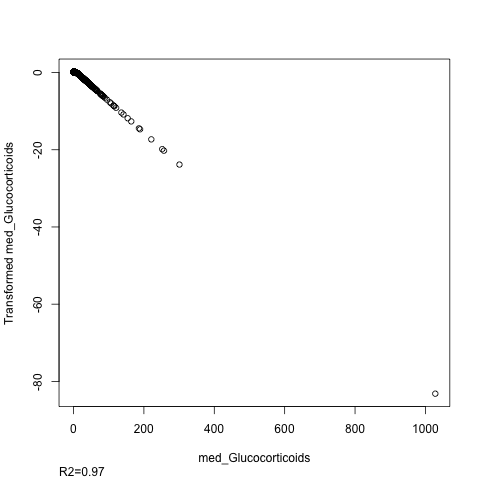

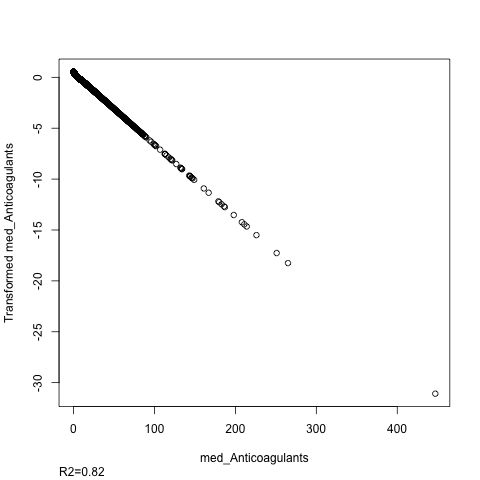

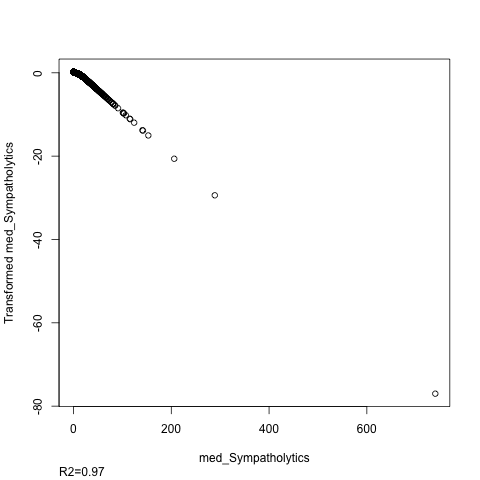

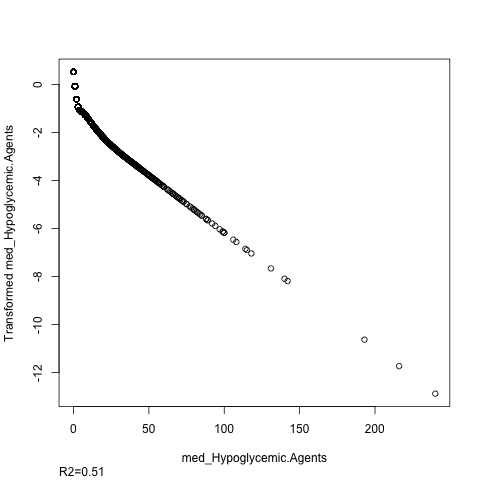

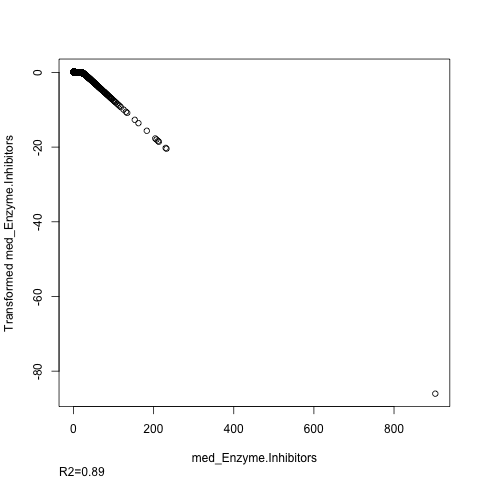

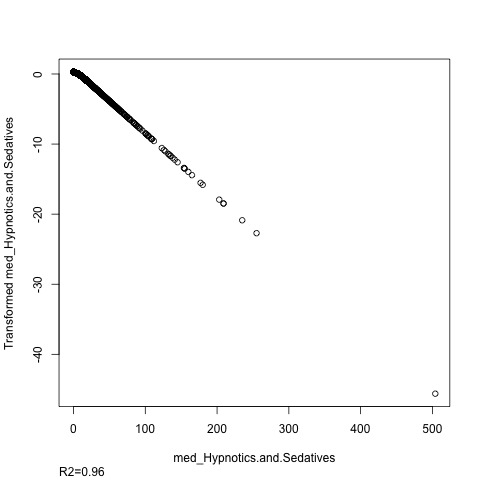

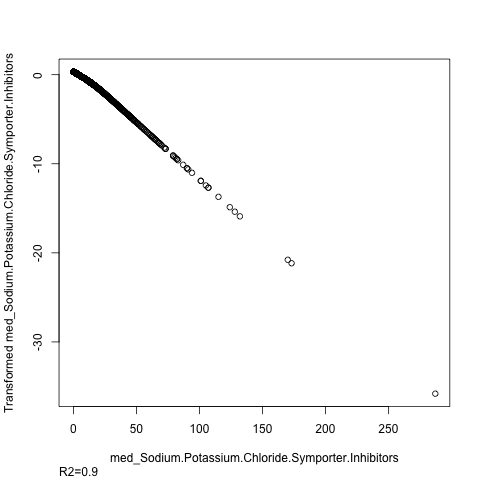

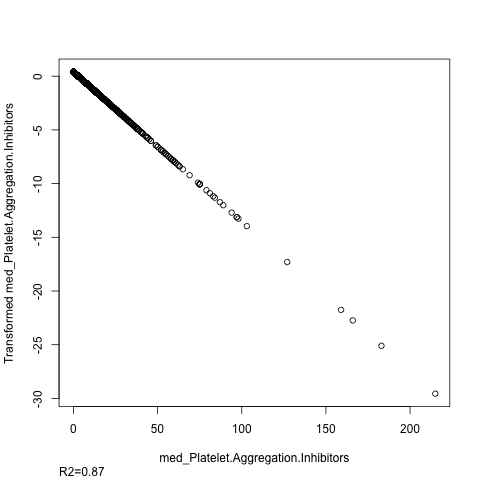

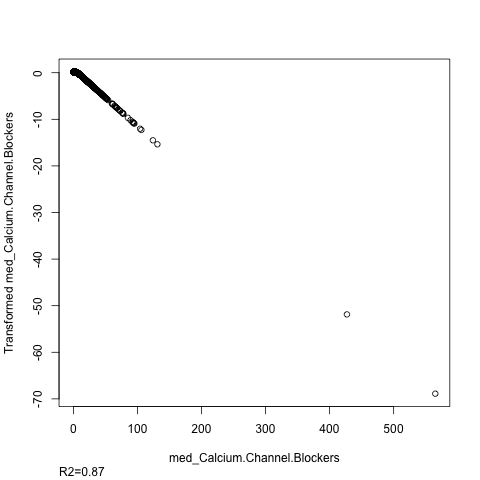

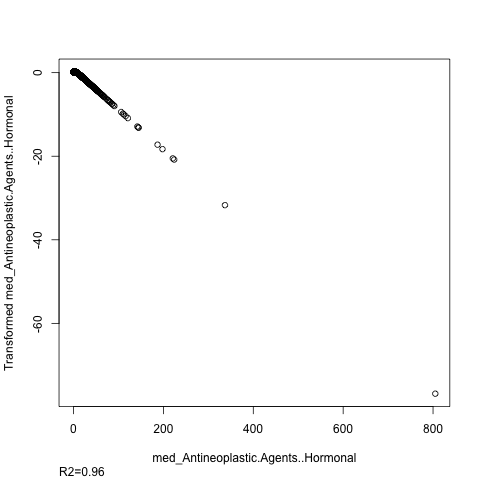

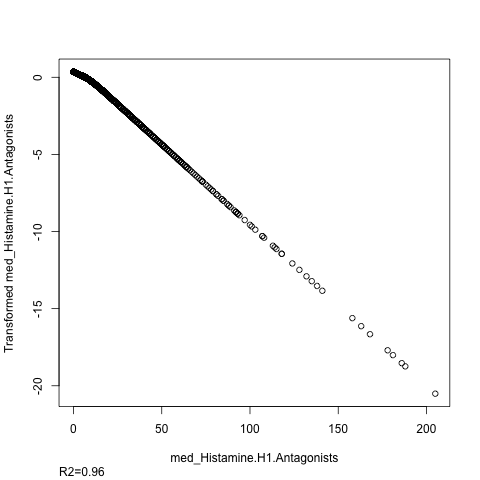

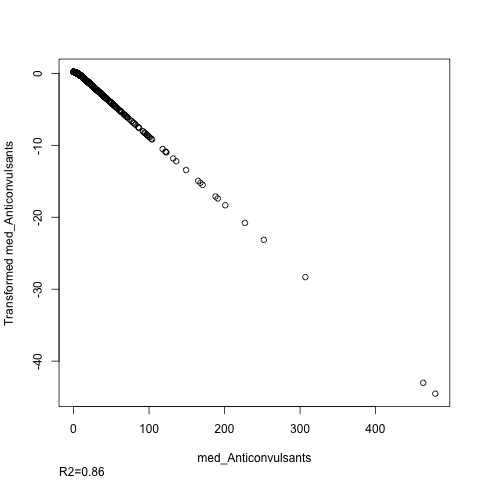

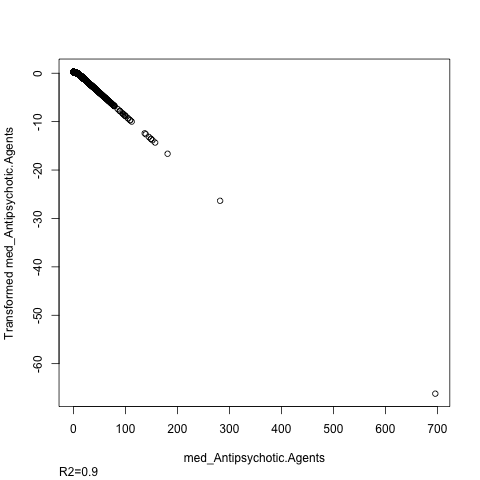

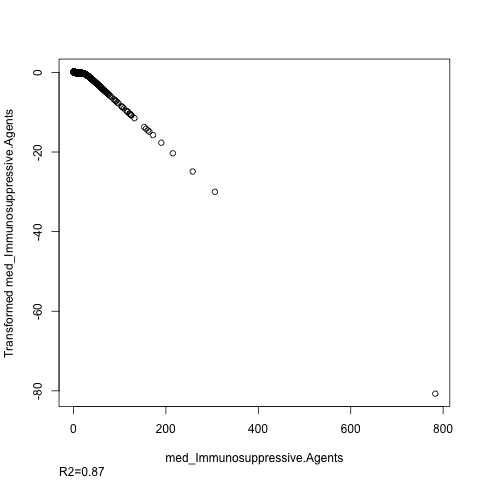

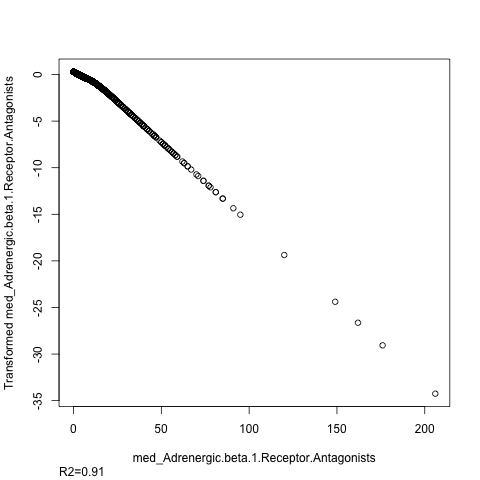

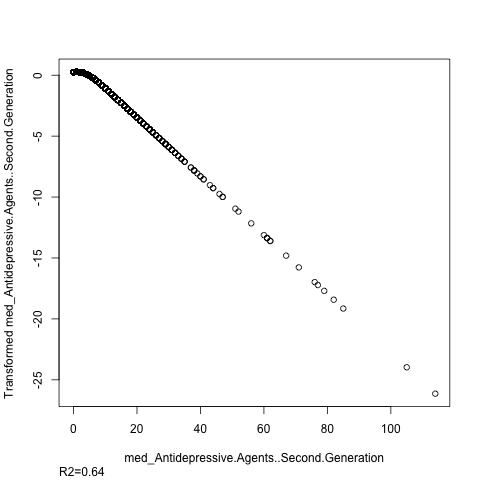

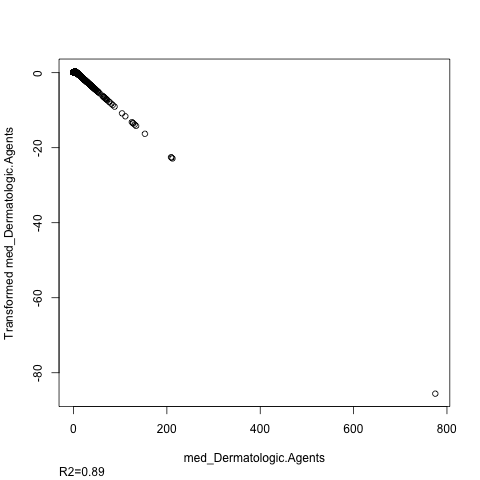

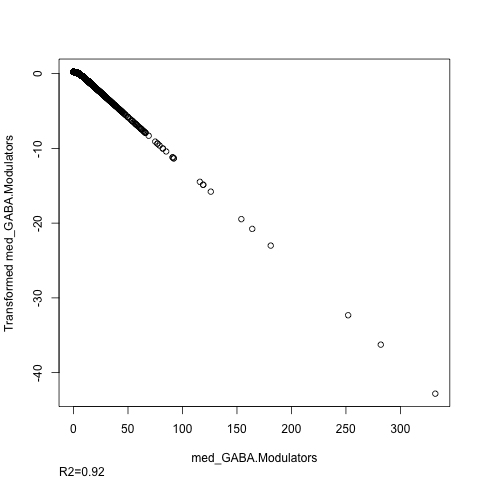

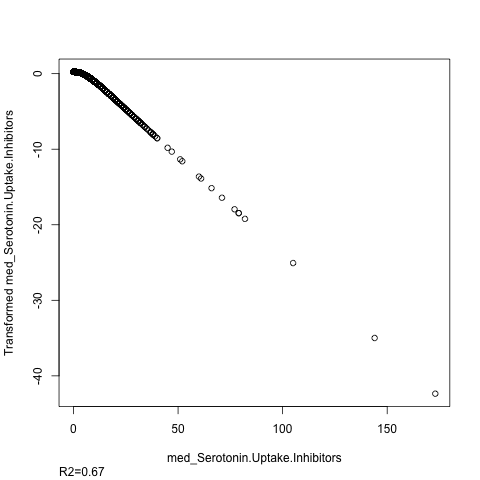

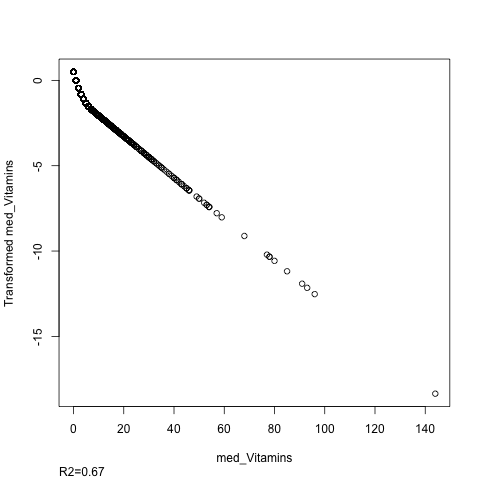

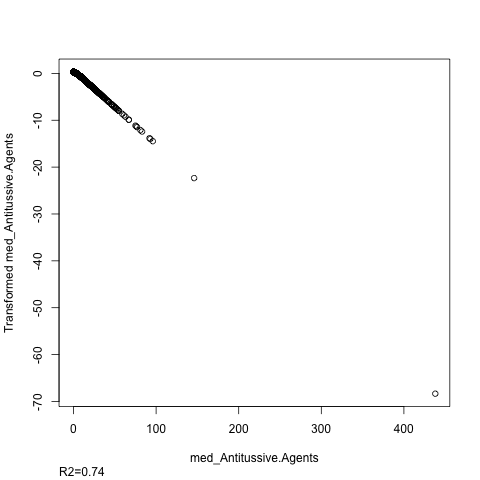

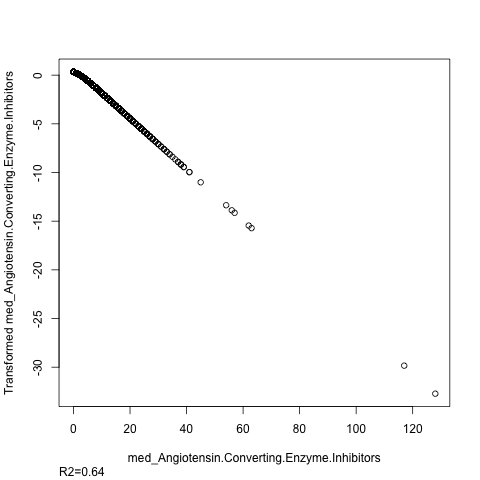

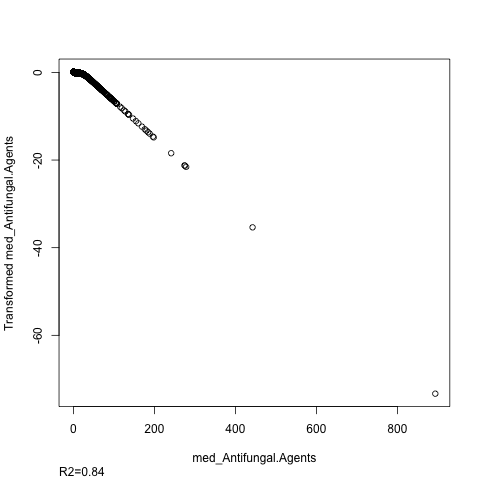

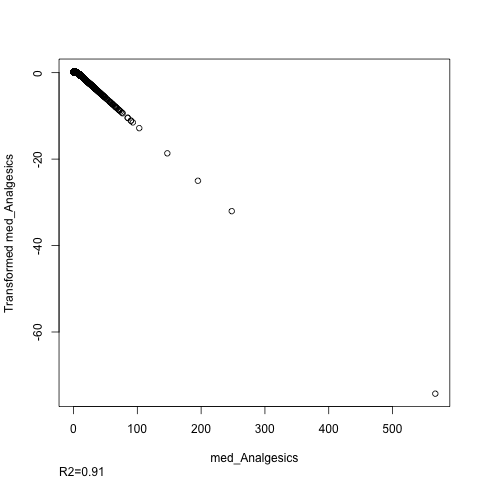

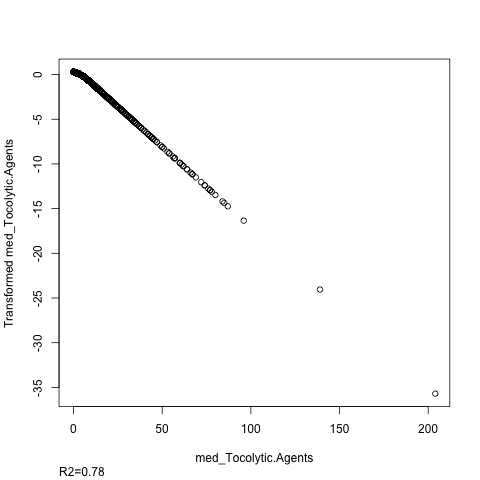

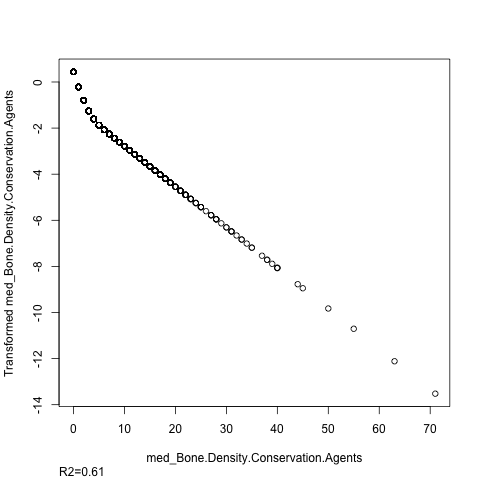

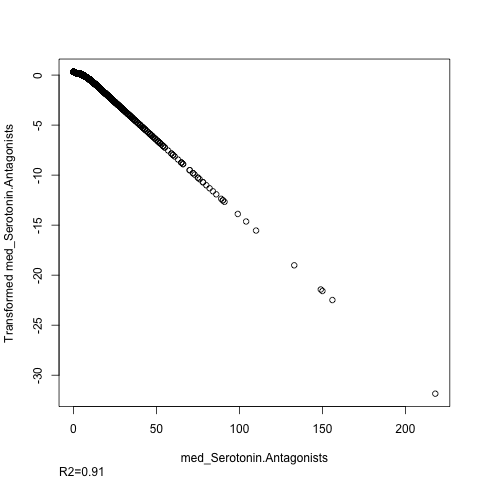

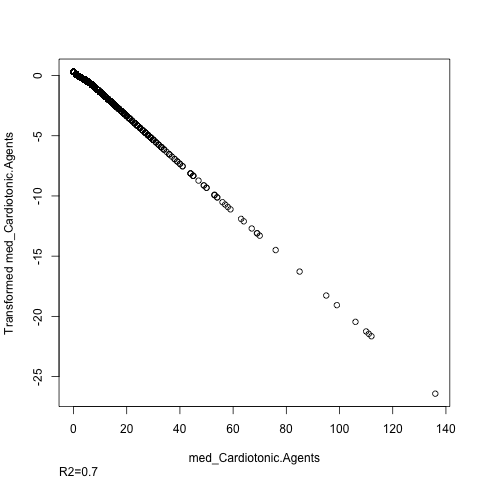

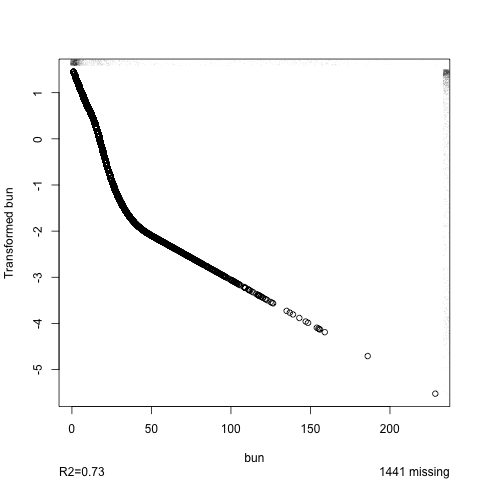

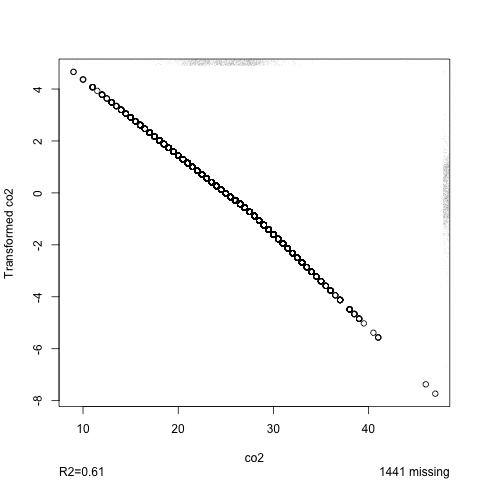

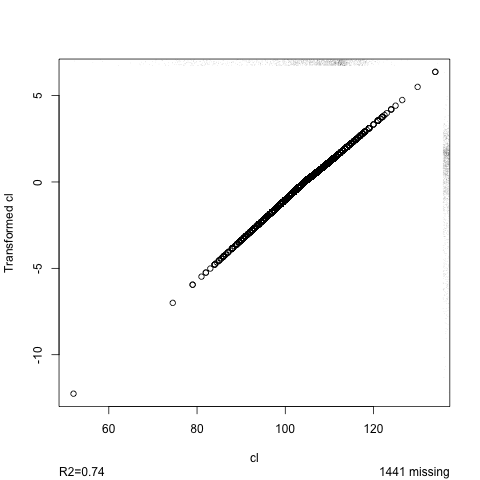

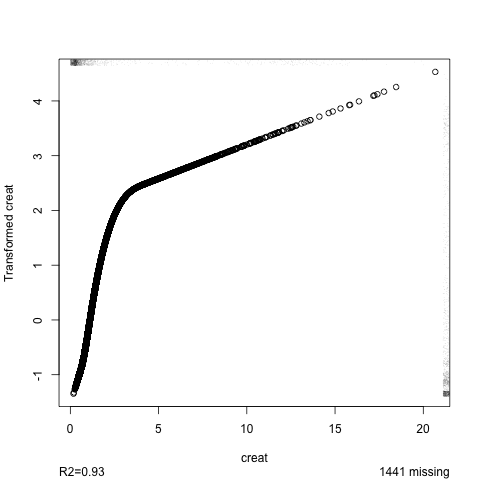

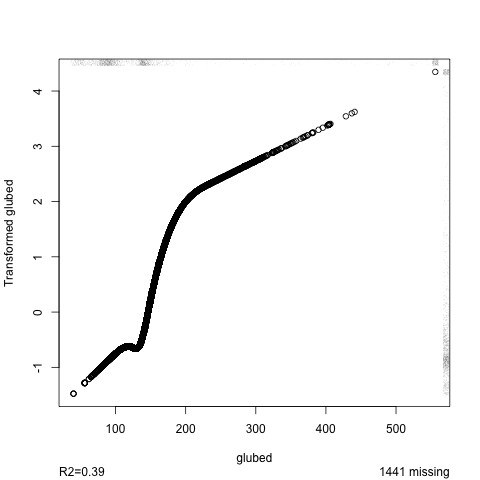

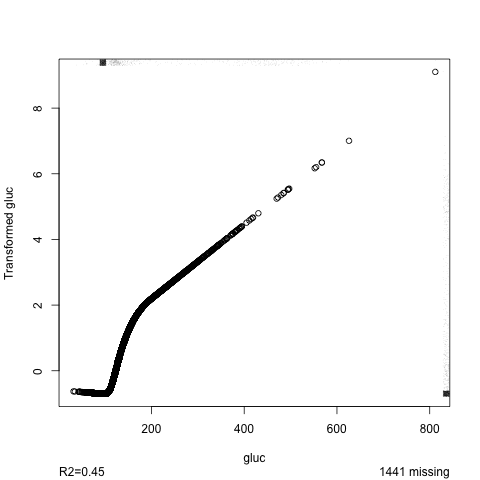

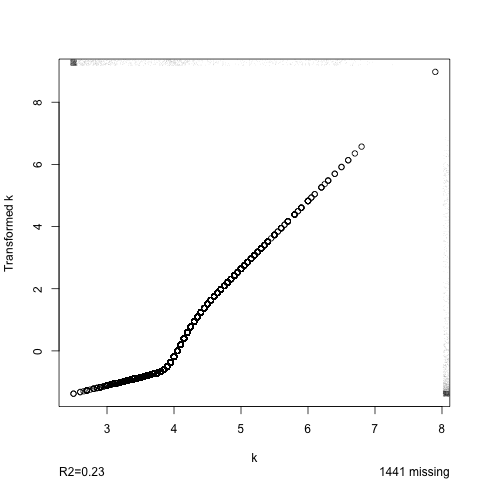

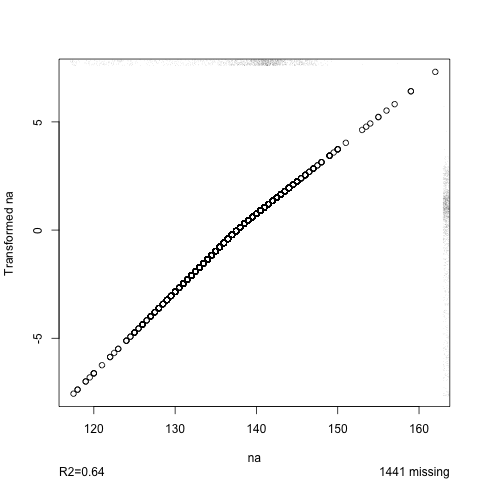

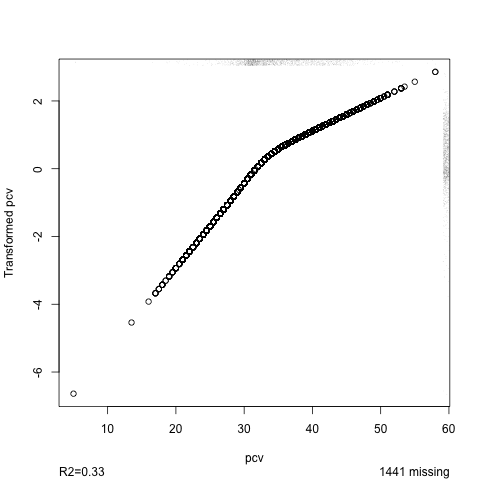

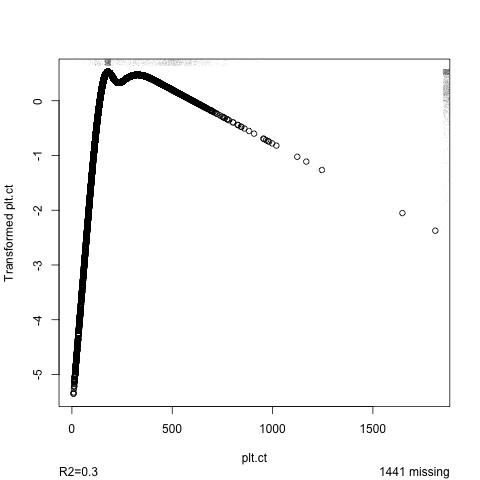

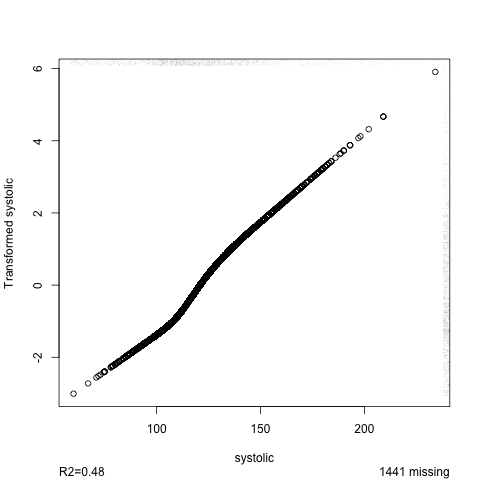

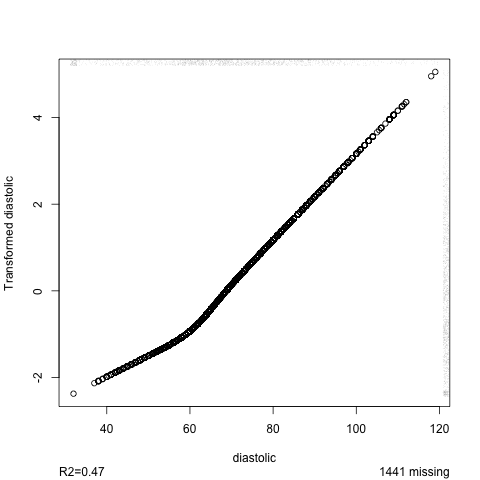

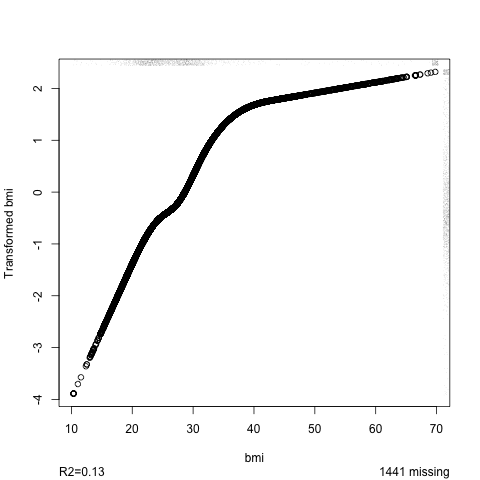

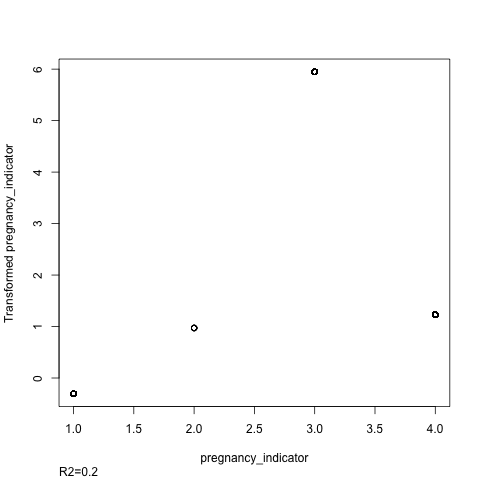

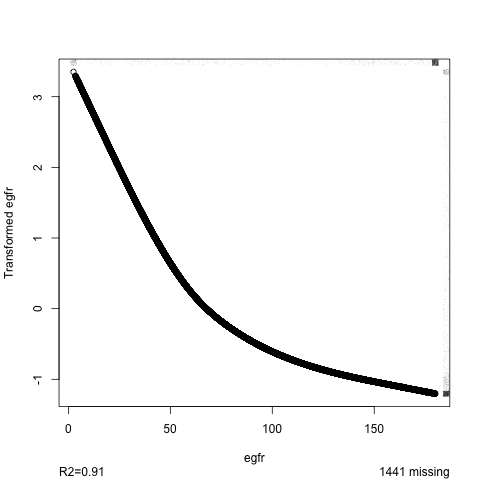

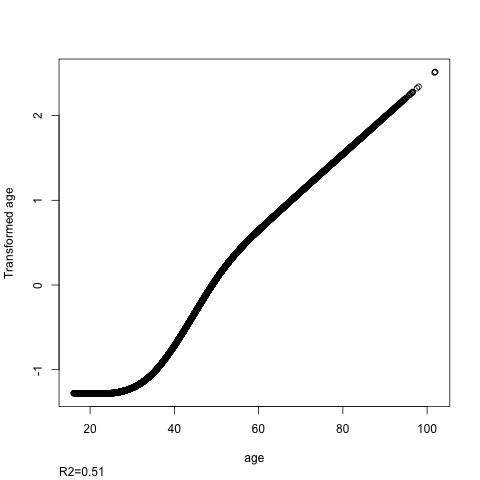

In [14]:
%%R 
# convert all predictors into R formula
vars <- paste(names(train), collapse=' + ')
formula <- as.formula(paste('~', vars))

# perform single imputation using transformed variables & canonical correlation
single_imp <- transcan(formula,
                       categorical=c('readmit_30d', 'sex', 'race', 'pregnancy_indicator'),
                       # variables with fewer than 3 unique knots
                       asis=c('icd_dx_perinatal', 'icd_dx_skin'),
                       transformed=TRUE, 
                       imputed=TRUE, 
                       # if wanting multiple imputations rather than a single:
                       #n.impute=5, 
                       show.na=TRUE, 
                       data=train)

# save to speed up process in case of dead kernel
save(single_imp, file='../data/single_imputation_training.RData')

In [ ]:
#%R summary(single_imp)

In [13]:
%%R -o train_imp
load('../data/single_imputation_training.RData')
train_imp <- data.frame(impute.transcan(single_imp, data=train, list.out=T))



Imputed missing values with the following frequencies
 and stored them in variables with their original names:

      bun       co2        cl     creat    glubed      gluc         k        na 
     1441      1441      1441      1441      1441      1441      1441      1441 
      pcv    plt.ct  systolic diastolic       bmi      egfr 
     1441      1441      1441      1441      1441      1441 


In [15]:
# any remaining NA's? 
assert(sum(train_imp.isnull().sum()>0)==0)

## Pickle Sets

In [ ]:
y_train = train_imp.pop('readmit_30d')
X_train = train_imp.copy()

In [ ]:
y_valid = valid_imp.pop('readmit_30d')
X_valid = valid_imp.copy()

In [ ]:
y_test = test_imp.pop('readmit_30d')
X_test = test_imp.copy()

In [ ]:
y_train.value_counts()/y_train.shape[0]

In [ ]:
y_valid.value_counts()/y_valid.shape[0]

In [ ]:
y_test.value_counts()/y_test.shape[0]

In [ ]:
data = {'y_train': y_train,
       'X_train': X_train,
       'y_valid': y_valid,
       'X_valid': X_valid,
       'y_test': y_test,
       'X_test': X_test}

In [ ]:
import pickle

with open("../data/data.pkl", "wb") as f:
    pickle.dump(data, f)